In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
from PIL import Image, ImageOps
from IPython.display import display
import tensorflow as tf
# import seaborn as sns
# sns.set()

## Obtain Images

In [3]:
covid = os.listdir('corona_dataset\\COVID')
noncovid = os.listdir('corona_dataset\\NonCOVID')

In [4]:
for i, png in enumerate(covid):
    covid[i] = os.path.join('corona_dataset\\COVID', png)
for i, png in enumerate(noncovid):
    noncovid[i] = os.path.join('corona_dataset\\NonCOVID', png)

In [5]:
covid.extend(noncovid)

In [6]:
img_list = [Image.open(path) for path in covid]

In [7]:
np.array(img_list[0].resize((512, 384))).shape

(384, 512, 4)

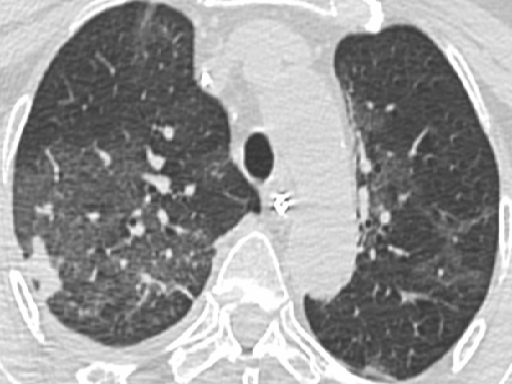

In [8]:
img_list[0].resize((512, 384))

## Build Autoencoder

In [9]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model

In [10]:
dropout = 0.2

input_layer = layers.Input(shape = (384, 512, 1))
c1 = layers.Conv2D(16, 3, 2, padding = 'same', activation = 'relu')(input_layer)
b1 = layers.BatchNormalization()(c1)
d1 = layers.Dropout(dropout)(b1)

c2 = layers.Conv2D(16, 3, 2, padding = 'same', activation = 'relu')(d1)
b2 = layers.BatchNormalization()(c2)
d2 = layers.Dropout(dropout)(b2)
p2 = layers.MaxPool2D(2, 2)(d1)
d2_p2 = layers.concatenate([d2, p2])

c3 = layers.Conv2D(32, 3, 2, padding = 'same', activation = 'relu')(d2_p2)
b3 = layers.BatchNormalization()(c3)
d3 = layers.Dropout(dropout)(b3)
p3 = layers.MaxPool2D(2, 2)(d2)
d3_p3 = layers.concatenate([d3, p3])

c4 = layers.Conv2D(32, 3, 2, padding = 'same', activation = 'relu')(d3_p3)
b4 = layers.BatchNormalization()(c4)
d4 = layers.Dropout(dropout)(b4)
p4 = layers.MaxPool2D(2, 2)(d3)
d4_p4 = layers.concatenate([d4, p4])

c5 = layers.Conv2D(64, 3, 2, padding = 'same', activation = 'relu')(d4_p4)
b5 = layers.BatchNormalization()(c5)
d5 = layers.Dropout(dropout)(b5)
p5 = layers.MaxPool2D(2, 2)(d4)
d5_p5 = layers.concatenate([d5, p5])

c6 = layers.Conv2D(64, 3, 2, padding = 'same', activation = 'relu')(d5_p5)
b6 = layers.BatchNormalization()(c6)
d6 = layers.Dropout(dropout)(b6)
p6 = layers.MaxPool2D(2, 2)(d5)
d6_p6 = layers.concatenate([d6, p6])

c7 = layers.Conv2D(128, 3, 2, padding = 'same', activation = 'relu')(d6_p6)
b7 = layers.BatchNormalization()(c7)
d7 = layers.Dropout(dropout)(b7)
p7 = layers.MaxPool2D(2, 2)(d6)
d7_p7 = layers.concatenate([d7, p7])

c8 = layers.Conv2D(128, (3, 4), (3, 4), padding = 'same', activation = 'relu')(d7_p7)
b8 = layers.BatchNormalization()(c8)
d8 = layers.Dropout(dropout)(b8)
p8 = layers.MaxPool2D((3, 4), (3, 4))(d7)
d8_p8 = layers.concatenate([d8, p8])

dconv0 = layers.Conv2DTranspose(128, (3, 4), (3, 4), padding = 'same', activation = 'relu')(d8_p8)
dconv0_b = layers.BatchNormalization()(dconv0)
dconv0_d = layers.Dropout(dropout)(dconv0_b)
add0 = layers.Add()([dconv0_d, d7])

dconv1 = layers.Conv2DTranspose(64, 3, 2, padding = 'same', activation = 'relu')(add0)
dconv1_b = layers.BatchNormalization()(dconv1)
dconv1_d = layers.Dropout(dropout)(dconv1_b)
add1 = layers.Add()([dconv1_d, d6])

dconv2 = layers.Conv2DTranspose(64, 3, 2, padding = 'same', activation = 'relu')(add1)
dconv2_b = layers.BatchNormalization()(dconv2)
dconv2_d = layers.Dropout(dropout)(dconv2_b)
add2 = layers.Add()([dconv2_d, d5])

dconv3 = layers.Conv2DTranspose(32, 3, 2, padding = 'same', activation = 'relu')(add2)
dconv3_b = layers.BatchNormalization()(dconv3)
dconv3_d = layers.Dropout(dropout)(dconv3_b)
add3 = layers.Add()([dconv3_d, d4])

dconv4 = layers.Conv2DTranspose(32, 3, 2, padding = 'same', activation = 'relu')(add3)
dconv4_b = layers.BatchNormalization()(dconv4)
dconv4_d = layers.Dropout(dropout)(dconv4_b)
add4 = layers.Add()([dconv4_d, d3])

dconv5 = layers.Conv2DTranspose(16, 3, 2, padding = 'same', activation = 'relu')(add4)
dconv5_b = layers.BatchNormalization()(dconv5)
dconv5_d = layers.Dropout(dropout)(dconv5_b)
add5 = layers.Add()([dconv5_d, d2])

dconv6 = layers.Conv2DTranspose(16, 3, 2, padding = 'same', activation = 'relu')(add5)
dconv6_b = layers.BatchNormalization()(dconv6)
dconv6_d = layers.Dropout(dropout)(dconv6_b)
add6 = layers.Add()([dconv6_d, d1])

dconv7 = layers.Conv2DTranspose(16, 3, 2, padding = 'same', activation = 'relu')(add6)
dconv7_b = layers.BatchNormalization()(dconv7)
dconv7_d = layers.Dropout(dropout)(dconv7_b)

output_layer = layers.Conv2D(1, 1, 1, padding = 'same', activation = 'sigmoid')(dconv7_d)

autoencoder = Model(inputs = input_layer, outputs = output_layer)
autoencoder.compile(optimizer = 'adam', loss = 'mse')

In [12]:
c8, p8

(<tf.Tensor 'conv2d_7/Identity:0' shape=(None, 1, 1, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_6/Identity:0' shape=(None, 1, 1, 128) dtype=float32>)

In [ ]:
autoencoder.summary()

## Image Information

In [9]:
import pandas as pd

In [10]:
ws = []
hs = []
for img in img_list:
    img = np.array(img)
    hs.append(img.shape[0])
    ws.append(img.shape[1])

In [11]:
df = pd.DataFrame({'ws': ws, 'hs': hs})

In [12]:
df.describe()

,ws,hs
count,704.000000,704.000000
mean,425.257102,303.255682
std,188.935102,146.562683
min,115.000000,61.000000
25%,314.750000,204.000000
50%,407.000000,292.000000
75%,512.000000,364.250000
max,1671.000000,1225.000000


In [13]:
print('Common ratio:\t1.3')
print('width:\t\t512')
print('height:\t\t384')

Common ratio:	1.3
width:		512
height:		384


## Train

In [14]:
mse = []
index = np.arange(704).astype(int)
batch_size = 64
img_size = [512, 384]
img_indexes = np.arange(len(img_list))

In [ ]:
img_list[2].resize((img_size[0], img_size[1]))

In [ ]:
autoencoder.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mse')

In [ ]:
epochs = 5
for epoch in range(epochs):
    
    print(f'Epoch {epoch}')
    
    np.random.shuffle(img_indexes)
    img_list = [img_list[img_index] for img_index in img_indexes]
    
    for i in range(11):
        
        # prepare images
        
        if i == 10:
            img_gen = img_list[i*batch_size:]
        else:
            img_gen = img_list[i*batch_size:(i+1)*batch_size]
        
        img_in_out = np.zeros((len(img_gen), img_size[1], img_size[0]))
        
        for j in range(len(img_gen)):
            
            img = img_gen[j].resize((img_size[0], img_size[1]))
            
            if np.random.uniform(0, 1, 1) > 0.5:
                img = ImageOps.flip(img)
            
            if len(np.array(img).shape) > 2:
                img_in_out[j] = np.array(img)[:, :, 0]
            else:
                img_in_out[j] = np.array(img)
        
        img_in_out = img_in_out/255.
        img_in_out = np.expand_dims(img_in_out, -1)
    
        # start training
        
        h = autoencoder.fit(img_in_out, img_in_out, epochs = 1, verbose = 0)
        mse.append(h.history['loss'][0])
        print('Process {:.0f}% done, MSE: {:.4f}'.format((i+1)*100/11, mse[-1]))

In [ ]:
fig = plt.figure(figsize = (8, 6))
plt.plot(mse)
plt.title('Autoencoder MSE Loss', fontsize = 15)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.legend(['final mse {:.4f}'.format(mse[-1])])
plt.tight_layout()
fig.savefig('autoencoder mse', transparent = True)

### Check result

In [15]:
# autoencoder = tf.keras.models.load_model('autoencoder_covid_384x512_best_so_far')

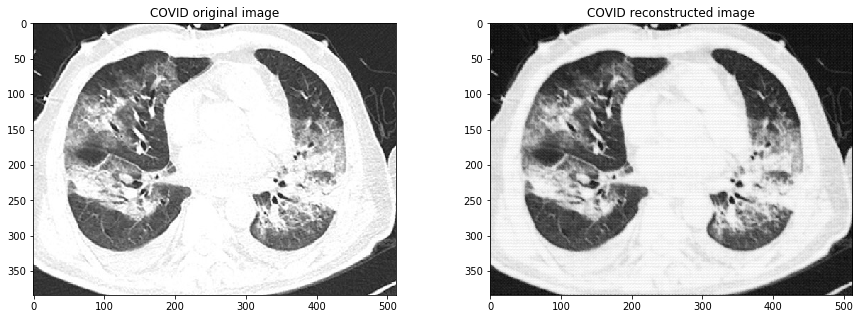

In [46]:
Img = Image.open(covid[89]).resize((img_size[0], img_size[1]))
img = np.array(Img)[:, :, 0]
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)
img = img/255.
pred = autoencoder.predict(img)
fig = plt.figure(figsize = (15, 5))
plt.subplot(121); plt.imshow(img[0, :, :, 0], 'gray'); plt.title('COVID original image')
plt.subplot(122); plt.imshow(pred[0, :, :, 0], 'gray'); plt.title('COVID reconstructed image')
fig.savefig('COVID reconstructed image 2', transparent = True)

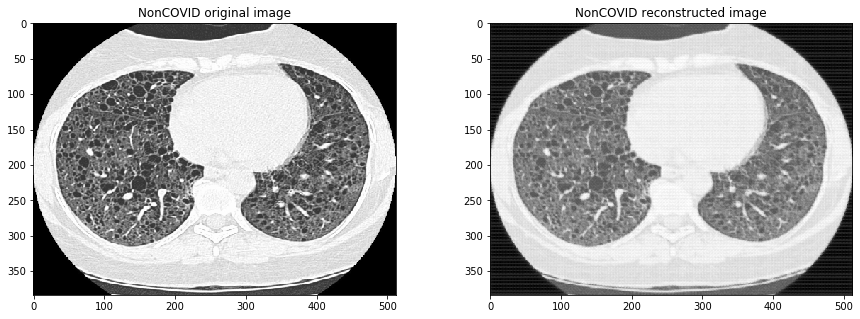

In [53]:
Img = Image.open(noncovid[34]).resize((img_size[0], img_size[1]))
img = np.array(Img)[:, :, 0]
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)
img = img/255.
pred = autoencoder.predict(img)
fig = plt.figure(figsize = (15, 5))
plt.subplot(121); plt.imshow(img[0, :, :, 0], 'gray'); plt.title('NonCOVID original image')
plt.subplot(122); plt.imshow(pred[0, :, :, 0], 'gray'); plt.title('NonCOVID reconstructed image')
fig.savefig('NonCOVID reconstructed image 2', transparent = True)

### Check feature maps in encoder

In [16]:
def find_max_filters(featurem_maps, number_filter = 6):
    filter_index = []
    global_sum = np.sum(np.sum(np.sum(pred, 0), 0), 0)
    for i in range(number_filter):
        filter_index.append(np.argmax(global_sum))
        global_sum[np.argmax(global_sum)] = -9999
    return filter_index
def find_min_filters(featurem_maps, number_filter = 6):
    filter_index = []
    global_sum = np.sum(np.sum(np.sum(pred, 0), 0), 0)
    for i in range(number_filter):
        filter_index.append(np.argmin(global_sum))
        global_sum[np.argmin(global_sum)] = 9999
    return filter_index

In [17]:
feature_model = Model(inputs = autoencoder.input,
                      outputs = autoencoder.get_layer(name = 'conv2d_1').output)

Best max filters indexes: [14, 8]
Best min filters indexes: [5, 6, 13]


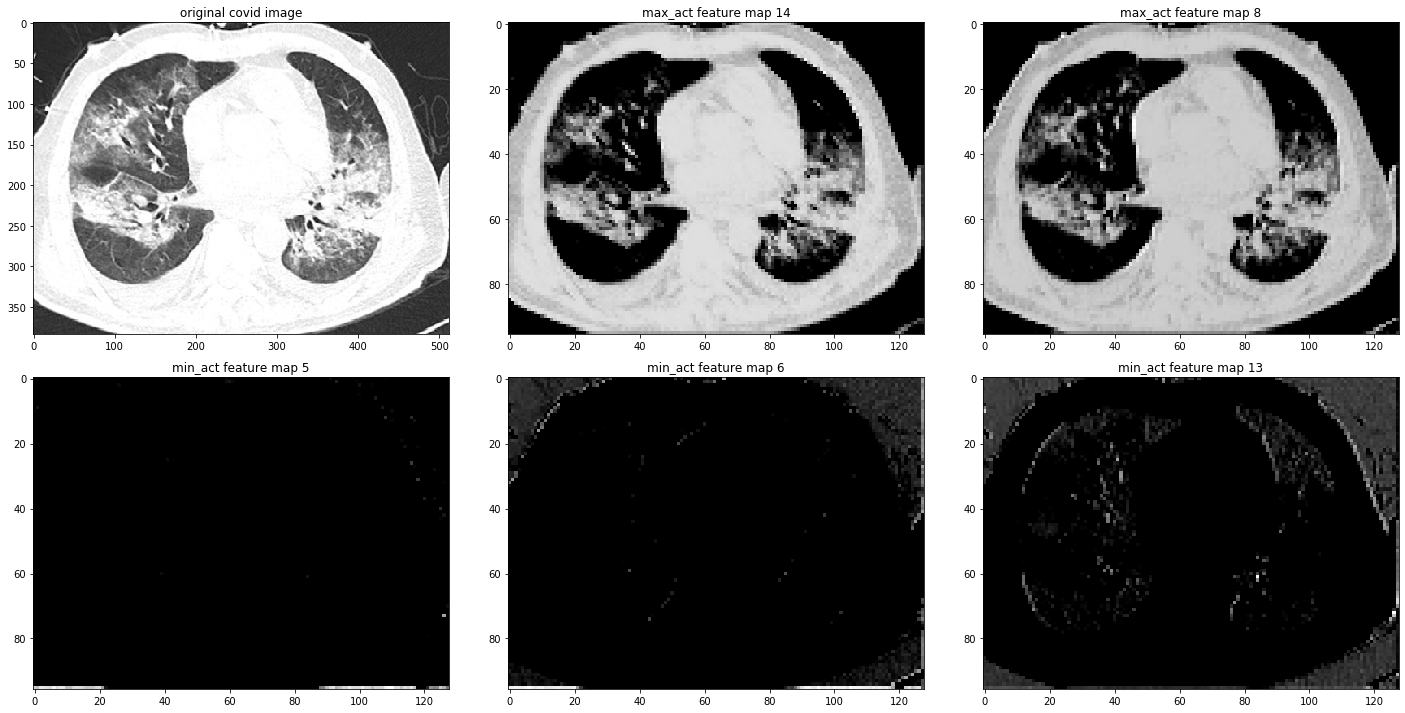

In [18]:
Img = Image.open(covid[89]).resize((img_size[0], img_size[1]))
img = np.array(Img)[:, :, 0]
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)
img = img/255.
pred = feature_model.predict(img)
# find best feature maps
max_f_index = find_max_filters(pred, 2)
min_f_index = find_min_filters(pred, 3)
#
print(f'Best max filters indexes: {max_f_index}')
print(f'Best min filters indexes: {min_f_index}')
fig = plt.figure(figsize = (20, 10))
j = 1
plt.subplot(2, 3, j)
plt.imshow(img[0, :, :, 0], 'gray')
plt.title('original covid image')
for i in range(2):
    j += 1
    plt.subplot(2, 3, j)
    plt.imshow(pred[0, :, :, max_f_index[i]], 'gray')
    plt.title(f'max_act feature map {max_f_index[i]}')
for i in range(3):    
    j += 1
    plt.subplot(2, 3, j)
    plt.imshow(pred[0, :, :, min_f_index[i]], 'gray')
    plt.title(f'min_act feature map {min_f_index[i]}')
plt.tight_layout()
fig.savefig('COVID feature maps', transparent = True)

Best max filters indexes: [14, 8]
Best min filters indexes: [5, 6, 13]


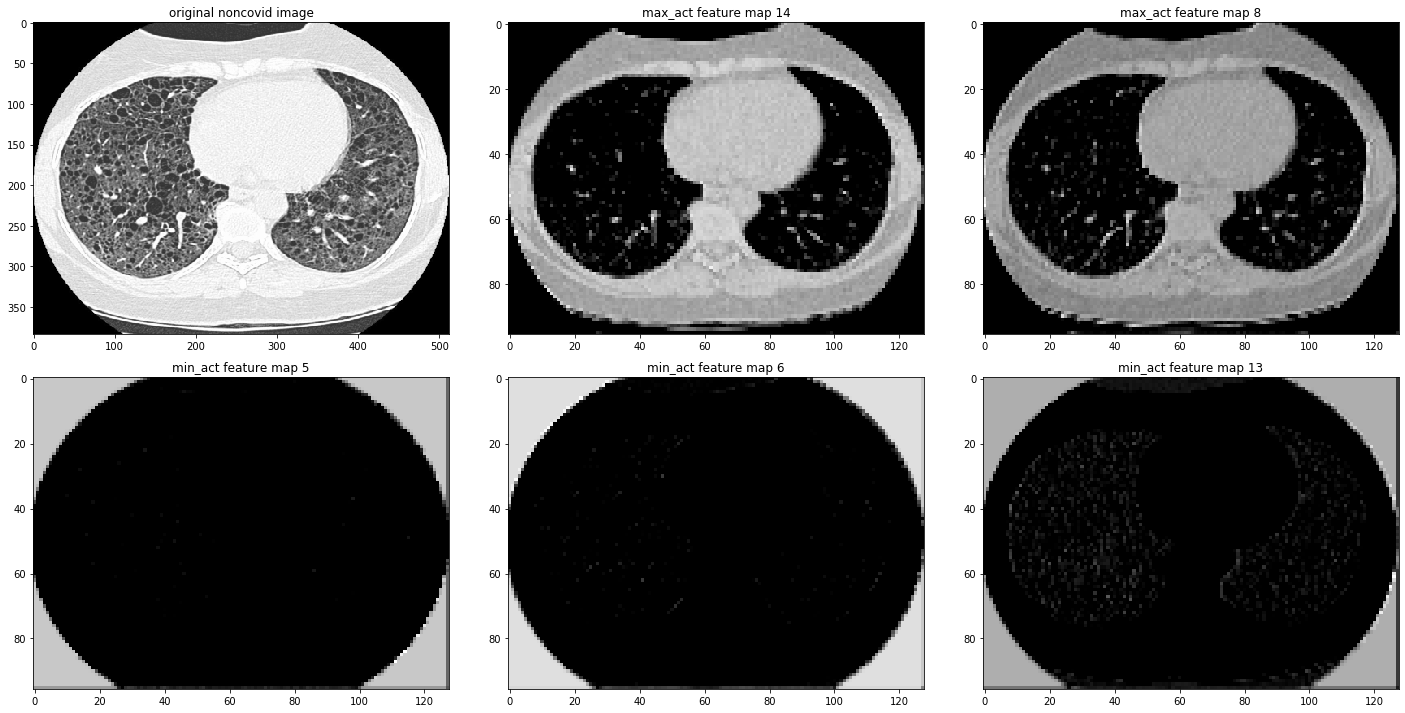

In [73]:
Img = Image.open(noncovid[34]).resize((img_size[0], img_size[1]))
img = np.array(Img)[:, :, 0]
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)
img = img/255.
pred = feature_model.predict(img)
# find best feature maps
max_f_index = find_max_filters(pred, 2)
min_f_index = find_min_filters(pred, 3)
#
print(f'Best max filters indexes: {max_f_index}')
print(f'Best min filters indexes: {min_f_index}')
fig = plt.figure(figsize = (20, 10))
j = 1
plt.subplot(2, 3, j)
plt.imshow(img[0, :, :, 0], 'gray')
plt.title('original noncovid image')
for i in range(2):
    j += 1
    plt.subplot(2, 3, j)
    plt.imshow(pred[0, :, :, max_f_index[i]], 'gray')
    plt.title(f'max_act feature map {max_f_index[i]}')
for i in range(3):    
    j += 1
    plt.subplot(2, 3, j)
    plt.imshow(pred[0, :, :, min_f_index[i]], 'gray')
    plt.title(f'min_act feature map {min_f_index[i]}')
plt.tight_layout()
fig.savefig('NonCOVID feature maps', transparent = True)

## Save Autoencoder

In [ ]:
autoencoder.save('autoencoder_covid_384x512_best_so_far')